In [1]:
import pandas as pd
import numpy as np

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# Chapter 8. 회귀분석
## 8-1 선형회귀
- 입력변수에 대한 선형함수 (기울기와 절편으로 이루어진 직선의 방정식)을 만들어 예측 수행
- 예측과 타겟 사이에 MSE를 최소화하는 회귀계수와 절편을 찾기
- 잔차제곱합을 최소화 하는 방법이라 특이값에 민감
- 다중선형회귀는 직선은 아니지만 각 계수와 그 변수들 사이 관계는 여전히 선형이므로 선형 모델
- 회귀모델을 적합한 후에는 잔차분석ㅇ르 통해 선형회귀의 가정을 위배하지 않는 유효한 모델인지 확인필요

[용어정리]
- X : 예측변수, feature
- Y : 결과변수, target
- $\hat{Y}$ : 예측값, predicted value
- w : 회귀계수 기울기, coefficient
- b : 회귀계수 절편, intercept
- Error : 오차, 관측치와 모회귀선의 편차
- Residual : 관측치와 표본회귀선과의 편차

[선형 회귀의 가정]
- 정규성 : 잔차가 정규분포형태
- 등분산성 : 독립변수와 무관하게 잔차의 분산이 일정
- 선형성 : 종속변수는 예측 변수와 회귀계수의 선형 결합
- 독립성 : 잔차들은 서로 독립. 독립변수들은 서로 선형적으로 독립

[회귀 분석의 전처리]
- 결측치, 이상치 처리
- 범주형 변수 처리 : n-1의 가변수를 갖도록 더미 코딩
  - 순서를 갖는 범주형 변수의 경우 순서에 따라 수치형 변수로 변환
- 영향치 처리 : 회귀 결과에 큰 영향에 미치는 경우 회귀에 높은 레버리지를 가지므로 처리 => Leverage H, Cook's distance, DFBETAS, DFFITS
- 다중공선성 : 독립변수들 간에 강한 상관관계, 기본가정인 독립성 위배
  - 회귀계수 분산이 비정상적으로 커져 계수 추정에 불안정성 유발 필요
  - 상관관계 높은 독립변수 일부 제거하거나, VIF 계산하여 일부 변수 제거
- 종속변수 스케일링 : 잔차분석 결과 등분산성, 정규성 위반할 경우 종속변수의 Box-cox, 로그변환 시도

[잔차 분석]
- 잔차분석 : 가정을 위반할 경우 전처리 과정을 다시 거치거나 데이터 리샘플링

### 8-1-1 단순선형회귀
- 독립변수와 종속변수의 정보를 가지고 일차 방정식의 계수 w,b를 찾는 과정
 
[용어정리]
- SSR = ESS(explained sum of squares)
- SSE = RSS(Residual sum of squares)
- SST = TSS(Total sum of squares)

In [2]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
Xa = data['data']; ya = data['target']
diabetes = pd.DataFrame(np.c_[Xa, ya], columns = data['feature_names']+['target'])

X = np.array(diabetes.filter(['bmi'])).ravel()
Y = np.array(diabetes.filter(['target'])).ravel()

print("[Direct Fitting]")
Xm = np.mean(X); Ym = np.mean(Y)
w = sum((X-Xm)*(Y-Ym)) / sum((X-Xm)**2)
b = Ym - w*Xm
print(f" slope estimate: {w:.3f}")
print(f" intercept estimation: {b:.3f}")
print(f" model : Y = {b:.3f} + {w:.3f}*X")

ypred = b + X*w
SSR = sum((Ym-ypred)**2)
SSE = sum((Y-ypred)**2)
SST = sum((Y-Ym)**2)
R2 = SSR/SST
R = np.corrcoef(X,Y)[0][1]
print(f"R2 {R2:.3f} (={R**2:.3f})")
print(f"R {R:.3f} (={np.sqrt(R2):.3f})")

# 회귀게수의 가설검정 (F검정, 유의수준 5%)
# H0 : 모든 회귀계수는 0이다.
treat_df = 1 # 처리 자유도 (설명변수의 개수)
resid_df = len(X) - treat_df - 1 # 잔차의 자유도(전체 데이터의 갯수 - 설명 변수의 개수 - 1)
MSR = SSR / treat_df
MSE = SSE / resid_df
fstat = MSR / MSE
print(f" MSE:{MSE:.3f}, MSR: {MSR:.3f} F stat: {fstat:.3f}")
print(f" 가설검정: F ({treat_df}, {resid_df}) pvalue {1-stats.f.cdf(fstat, treat_df, resid_df):.3f}")

print("[Library Fitting]")
import statsmodels.api as sm
X = diabetes.filter(['bmi'])
Y = diabetes.filter(['target'])

Xc = sm.add_constant(X)
model = sm.OLS(Y, Xc)
fitted = model.fit()
resid = fitted.resid
print(fitted.summary())

[Direct Fitting]
 slope estimate: 949.435
 intercept estimation: 152.133
 model : Y = 152.133 + 949.435*X
R2 0.344 (=0.344)
R 0.586 (=0.586)
 MSE:3908.140, MSR: 901427.314 F stat: 230.654
 가설검정: F (1, 440) pvalue 0.000
[Library Fitting]
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     230.7
Date:                Sun, 26 May 2024   Prob (F-statistic):           3.47e-42
Time:                        11:30:43   Log-Likelihood:                -2454.0
No. Observations:                 442   AIC:                             4912.
Df Residuals:                     440   BIC:                             4920.
Df Model:                           1                                         
Covariance Type:            nonrobust               

In [3]:
# sklearn method
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(X, Y)
pred = LR.predict(X)

print("회귀계수: ", LR.coef_)
print("절편: ", LR.intercept_)
print("결정계수: {:.3}".format(LR.score(X,Y)))

회귀계수:  [[949.43526038]]
절편:  [152.13348416]
결정계수: 0.344


In [4]:
# 기울기, 절편, Y의 평균값에 대한 추정과 검정
print("[추정과 검정]")
X = np.array(diabetes.filter(['bmi'])).ravel()
Y = np.array(diabetes.filter(['target'])).ravel()

# resid_std 계산하여 세 가지 추정과 검정에 사용
resid_std = np.sqrt(MSE)
resid_std2 = np.std(fitted.resid, ddof=2)
print(f"잔차 표준오차 : {resid_std:.3f}(= {resid_std2:.3f}")

print("1. 기울기:")
print(f" point estimation: {w:.3f}")
se = resid_std / np.sqrt(sum((X-Xm)**2))
print(f" point estimation SE: {se:.3f}")
alpha = 0.05
start = w + stats.t.ppf(alpha/2, resid_df) * se
end = w + stats.t.ppf(1-alpha/2, resid_df) * se
print(f"conf interval : {start:.3f}~{end:.3f}")

# slope test
w0 = 0
tstat = (w - w0) / se
print(f" stat {tstat:.3f}, pvalue {(1-stats.t.cdf(tstat, resid_df))*2:.3f}")

print("2. 절편: ")
Xi = 0; Y1 = b + w*Xi
print(f" point estimation: {Y1:.3f}")
se2 = resid_std * np.sqrt(1/len(X) + (Xi-Xm)**2/sum((X-Xm)**2))
print(f" point estimation se: {se2:.3f}")
start2 = Y1 + stats.t.ppf(alpha/2, resid_df)*se2
end2 = Y1 + stats.t.ppf(1-alpha/2, resid_df)*se2
print(f" conf interval: {start2:.3f} ~ {end2:.3f}")

# intercept test
b0 = 0
tstat2 = (b-b0)/se2
print(f" stat :{tstat2:.3f}, pvalue {(1-stats.t.cdf(np.abs(tstat2), resid_df))*2}")


[추정과 검정]
잔차 표준오차 : 62.515(= 62.515
1. 기울기:
 point estimation: 949.435
 point estimation SE: 62.515
conf interval : 826.570~1072.301
 stat 15.187, pvalue 0.000
2. 절편: 
 point estimation: 152.133
 point estimation se: 2.974
 conf interval: 146.289 ~ 157.978
 stat :51.162, pvalue 0.0


In [5]:
print(f" 3. 특정한 X값 {Xi:.2f}일 때 Y의 평균값: ")
Xi = 0.15; Y2 = b + w * Xi
print(f" point estimate: {Y2:.3f}")
se3 = resid_std * np.sqrt(1/len(X) + (Xi - Xm)**2 / sum((X-Xm)**2))
print(f" point estimate se: {se3:.3f}")

start3 = Y2 + stats.t.ppf(alpha/2, resid_df) * se3
end3 = Y2 + stats.t.ppf(1 - alpha/2, resid_df) * se3
print(f" conf interval : {start3:.3f} ~ {end3:.3f}")

# Y mean hypothesis test
# H0 : Y2_0 = 0
alpha = 0.05; Y2_0 = 0
tstat3 = (Y2-Y2_0) / se3
print(f" stat {tstat3:.3f}, pvalue {(1-stats.t.cdf(np.abs(tstat3), resid_df))*2}")

 3. 특정한 X값 0.00일 때 Y의 평균값: 
 point estimate: 294.549
 point estimate se: 9.837
 conf interval : 275.215 ~ 313.883
 stat 29.942, pvalue 0.0


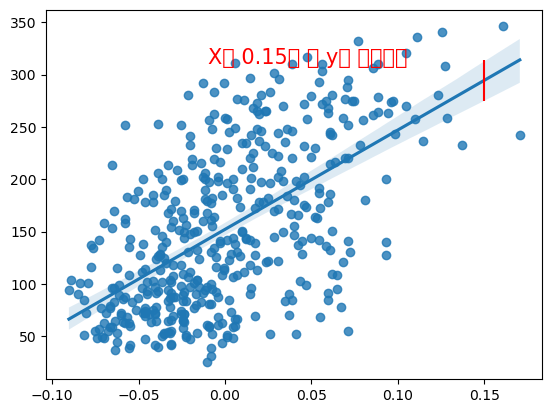

In [6]:
# 회귀직선의 신뢰대 (각 X값에 대한 y평균값들의 신뢰구간) 시각화
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)
sns.regplot(x=X, y=Y, ax=ax)
ax.vlines(x=0.15, ymin=start3, ymax=end3, color='red')
ax.text(-0.01, 310, f"X가 {Xi}일 떄 y의 신뢰구간", color='red', size=15)
plt.show()

### 8-1-2 다중선형회귀

In [7]:
from sklearn.datasets import load_diabetes
import statsmodels.api as sm
data = load_diabetes()
Xa = data['data']; ya = data['target']
diabetes = pd.DataFrame(np.c_[Xa, ya], columns = data['feature_names'] + ['target'])

X = diabetes.filter(['bmi', 'age', 'sex', 'bp'])
y = diabetes.filter(['target'])

def multiR_fitted(X, y):
    X_ = sm.add_constant(X)
    model = sm.OLS(y, X_)
    fitted = model.fit()
    return fitted, fitted.summary()

fitted, summary = multiR_fitted(X, y)
print(summary)

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     72.91
Date:                Sun, 26 May 2024   Prob (F-statistic):           2.70e-47
Time:                        11:30:45   Log-Likelihood:                -2434.2
No. Observations:                 442   AIC:                             4878.
Df Residuals:                     437   BIC:                             4899.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.853     53.329      0.0

### 영향치 판단
p는 예측변수 갯수, n은 데이터 크기, 아래는 영향치 판단 척도
- Cook's distance : 레버리지와 잔차의 크기를 합쳐서 영향력 판단
  - 4/(n-p-1)보다 크면 영향력 높음. 쿡의 거리가 기준값인 1보다 클 경우 영향치로 간주
- DFBETAS : 값이 커지면 영향치 혹은 이상치 일 가능성 높음
  - 기준값은 2나 2/$sqrt{n}$을 사용하며, 클 경우 영향치
- DFFITS : 특정 관측치 제외 시 종속변수 예측치의 변화정도
  - 기준값인 $2\sqrt{(p+1)/n}$보다 클 수록 영향치 가능성 높음
- Leverage H : $2(p+1)/n$이상의 값들은 레버리지가 높은 데이터값

In [8]:
# 각 데이터의 영향치 판단값 계산
def get_influence(fitted):
    cook = fitted.get_influence().cooks_distance[0]
    dfb = fitted.get_influence().dfbetas[:,0]
    dff = fitted.get_influence().dffits_internal[0]
    lev = fitted.get_influence().hat_matrix_diag
    df = pd.DataFrame({"cooks_distance":cook, 'dfbetas':dfb, 'dffits':dff, 'leverageH':lev})

    return df

influ_df = get_influence(fitted)
print(influ_df)

     cooks_distance   dfbetas    dffits  leverageH
0          0.001516 -0.043867 -0.087062   0.008908
1          0.000350 -0.024198 -0.041811   0.006743
2          0.001478 -0.033422 -0.085965   0.014950
3          0.003736  0.061662  0.136681   0.011133
4          0.000003 -0.002047 -0.003822   0.007869
..              ...       ...       ...        ...
437        0.000049 -0.008507 -0.015638   0.007629
438        0.000002 -0.001460 -0.003347   0.011865
439        0.000045 -0.008749 -0.015046   0.006677
440        0.000531  0.026808  0.051509   0.008339
441        0.000031 -0.005440 -0.012411   0.011747

[442 rows x 4 columns]


In [9]:
# 영향치로 판단되는 데이터 추출
def find_idx_cooks(fitted):
    cook = fitted.get_influence().cooks_distance[0]
    P = fitted.get_influence().k_vars
    score = 4 / (len(y) - P - 1)
    if score <= 1:
        idx = np.where(cook > score)[0]
    else:
        idx = np.where(cook > 1)[0]
    
    return idx

idx = find_idx_cooks(fitted)
print("Cook's distance 기준 영향치: ", idx)

def find_idx_dfbetas(fitted):
    dfb = fitted.get_influence().dfbetas[:, 0]
    n = fitted.df_resid + fitted.df_model + 1
    score = 2 / np.sqrt(n)
    if score <= 2:
        idx = np.where(dfb > score)[0]
    else:
        idx = np.where(dfb > 2)[0]
    
    return idx

idx2 = find_idx_dfbetas(fitted)
print("DFBETAS 기준 영향치: ", idx2)

def find_idx_dffits(fitted):
    dff = fitted.get_influence().dffits_internal[0]
    P = fitted.get_influence().k_vars
    n = fitted.df_resid + fitted.df_model + 1
    score = 2 * np.sqrt((P+1)/n)
    idx = np.where(dff > score)[0]
    
    return idx
idx3 = find_idx_dffits(fitted)
print("DFFITS 기준 영향치: ", idx3)

def find_idx_leverageH(fitted):
    lh = fitted.get_influence().hat_matrix_diag
    P = fitted.get_influence().k_vars
    n = fitted.df_resid + fitted.df_model + 1
    score = 2*(P+1)/n
    idx = np.where(lh > score)[0]
    
    return idx

idx4 = find_idx_leverageH(fitted)
print("Leverage H 기준 영향치 : ", idx4)

Cook's distance 기준 영향치:  [  9  78  92 102 117 141 147 152 204 211 256 289 328 336 343 380 417]
DFBETAS 기준 영향치:  [  9  37  78 102 141 152 190 218 359 364]
DFFITS 기준 영향치:  [  9 102 117 141 256]
Leverage H 기준 영향치 :  [130 145 256 261 340 366 367 408]


### VIF 계산
- 선형 회귀에 변수가 추가되는 경우 매개변수 추정의 분산 증가에 대한 측정치
- 다중공선성의 척도. 10이상 일 경우 높은 상관성
- 범주형 변수가 포함되어 있을 경우, 더미 코딩을 통해 다중공선성 문제를 피할 수 있다
  - p 번째 열을 추가하지 않고 더미코딩

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

def check_cif(X, y):
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    model.fit()
    vif_df = pd.DataFrame(columns=['feature', 'VIF'])
    for i in range(1, len(model.exog_names)):        
        vif_df.loc[i, 'feature'] = model.exog_names[i]
        vif_df.loc[i, 'VIF'] = round(VIF(model.exog, i), 3)
    return vif_df.sort_values('VIF', ascending=False)

print(check_cif(X, y))

  feature    VIF
4      bp  1.343
1     bmi   1.19
2     age  1.143
3     sex  1.073


### 변수 선택과 가능도
- AIC를 최소로 하거나 수정 결정계수를 최대로 하는 변수 조합의 최적 회귀 방정식
  - 단계적방법, 전진선택법, 후진제거법
[변수 선택 기준들]
- p는 설명변수의 개수, n은 데이터의 개수, SST는 전체제곱합, SSE는 잔차제곱합, MSE는 잔체제곱합의 평균, log$L_i$는 로그가능도의 최댓값
  - 수정결정계수 : 모델에 변수를 추가할수록 기존의 결정계수에 불이익을 주며 모형의 적합도 판단
    $Adjusted\ R^2 = 1 - (1- R^2)(n-1)/(n-p-1)$
  - AIC : 모델에 변수를 추가할수록 불이익을 주는 오차 측정법
    $AIC = -2logL_i + 2(p+1)$, 절편이 있는 경우 p+1, 없으면 p
  - BIC : AIC와 비슷하나 변수 추가에 대해 더 강한 벌점
    $BIC = -2logL_i + log(n)(p+1)$ 절편이 있는 경우 p+1, 없으면 p
  - Mallows $C_p$ : $C_p$값이 작고, (p + 상수의 개수)와 비슷할 수록 편향이 작고 우수한 모델
    - 후보 설명변수들로 적합한 모델의 $SSE_p$와 전체 설명변수로 적합했을 때의 $MSE_{full}$ 이용
    $C_p = \frac{SSE_p}{MSE_{full}} - n + 2(p+1)$

[가능도] 
- 우도 : 확률분포의 모수가 어떤 확률변수의 표집갑과 일관되는 정도
    - 주어진 표집값에 대해 모수의 가능도는 이 모수를 따르는 분포가 주어진 관측값에 대하여 부여하는 확률. 가능도가 높을수록 모델의 추정량이 실제 모수값에 가깝다
    - 확률분포가 아니며, 합한 값이 1이 되지 않을수도 있다
- 로그 가능도 : 확률분포함수가 곱셈 꼴로 나올 때, 미분 계산의 편의성을 위해 가능도 함수 대신 사용
  - 로그함수는 단조증가하므로, 가능도 함수에서 최댓값을 갖는 위치와 로그 가능도에서 최댓값을 가지는 위치는 동일
- 선형회귀에서 잔차는 서로 독립이고, 평균은 0, 모분산은 $\sigma^2$인 정규분포를 따른다는 가정
=> 잔차의 가정을 활용하여, 모수인 회귀계수($\beta_0, \beta_1$)와 모분산($\sigma^2$)에 대해 가능도를 계산할 수 있다
  - 각 관측값에 대하여 모수가 $\beta_0, \beta_1, \sigma^2$ 일 때, $y_i$일 확률값을 계산하고, 이 확률값들은 서로 독립이기에 모두 곱하여 가능도를 얻는다 / 실제로는 아직 모수값을 모르므로 그 추정값인 $b_0, b_1, s^2$를 사용한다.
    - 선형 회귀모델 가능도 함수:
      $$\prod^n_{i=1}p(y_i|x_i; \beta_0, \beta_1, \sigma^2) = \prod^n_{i=1}\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(y_i-(\beta_0+\beta_1x_i))^2}{2\sigma^2}}$$
    - 정규분포의 확률밀도함수:
     $$N(x|\mu,\sigma^2)=\frac{1}{\sqrt{2\pi\sigma^2}})=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$


In [11]:
# 모든 변수를 포함한 full model
print("full model = const, bp, bmi, age, sex")
fitted, summary = multiR_fitted(X, y)
R2 = fitted.rsquared; n = fitted.nobs; p = fitted.df_model # 설명 변수 갯수
constant = 'const' in fitted.params.keys() # 절편 유무
SSE = sum((fitted.resid)**2) # full model의 잔차제곱합
MSE_full = SSE / (n-p-1)
adj_R2 = 1 - (1 - R2) * (n-1) / (n-p-1)
print(f" 수정 결정계수: {adj_R2:.3f}")

# 수기 계산 및 라이브러리 계산
llf = -n/2*np.log(2*np.pi) - n/2*np.log(SSE/n) - n/2 # 로그 가능도 (= fitted.llf)
aic = -2*llf + 2*(p + constant) # fitted.aic
bic = -2*llf + np.log(n) * (p + constant) # fitted.bic
print(f" AIC: {aic:.1f} (={fitted.aic:.1f})")
print(f" BIC: {bic:.1f} (={fitted.bic:.1f})")

cp = SSE/MSE_full - n + 2*(p+1)
print(f" Cp {cp:.1f} -> 변수+상수 개수의 값 {p+constant}")

full model = const, bp, bmi, age, sex
 수정 결정계수: 0.395
 AIC: 4878.4 (=4878.4)
 BIC: 4898.8 (=4898.8)
 Cp 5.0 -> 변수+상수 개수의 값 5.0


In [12]:
# 일부 변수만 포함한 후보 모델
print("후보 model = const, bp, bmi")
fitted2, summary2 = multiR_fitted(X.filter(['bp', 'bmi']), y)
R2 = fitted2.rsquared; n = fitted2.nobs; p = fitted2.df_model # 설명 변수 갯수
constant = 'const' in fitted2.params.keys() # 절편 유무
SSE2 = sum((fitted2.resid)**2) # full model의 잔차제곱합
adj_R2 = 1 - (1 - R2) * (n-1) / (n-p-1)
print(f" 수정 결정계수: {adj_R2:.3f}")

# 수기 계산 및 라이브러리 계산
llf = -n/2*np.log(2*np.pi) - n/2*np.log(SSE/n) - n/2 # 로그 가능도 (= fitted.llf)
aic = -2*llf + 2*(p + constant) # fitted.aic
bic = -2*llf + np.log(n) * (p + constant) # fitted.bic
print(f" AIC: {aic:.1f} (={fitted2.aic:.1f})")
print(f" BIC: {bic:.1f} (={fitted2.bic:.1f})")

cp = SSE2/MSE_full - n + 2*(p+1)
print(f" Cp {cp:.1f} -> 변수+상수 개수의 값 {p+constant}")

후보 model = const, bp, bmi
 수정 결정계수: 0.393
 AIC: 4874.4 (=4877.5)
 BIC: 4886.6 (=4889.8)
 Cp 4.1 -> 변수+상수 개수의 값 3.0


In [13]:
# 단계적 선택법
from itertools import combinations

def stepwise_method(X, y, criterion='AIC'): # BIC, CP, adj_R2
    result = pd.DataFrame()
    feature_combis = []
    for i in range(1, len(X.columns)+1):
        feature_combis += list(combinations(X.columns, i))
    feature_combis.reverse() # p 갯수 내림차순

    for j, feature_combi in enumerate(feature_combis):
        X_ = X.filter(feature_combi)
        X_ = sm.add_constant(X_)
        model = sm.OLS(y, X_)
        fitted = model.fit()
        n = fitted.nobs; p = fitted.df_model
        if j == 0:
            MSE_full = fitted.mse_resid # full model MSE

        aic = fitted.aic; bix = fitted.bic; 
        cp = sum((fitted.resid)**2)/MSE_full - (n-2*(p+1))
        adj_R2 = fitted.rsquared_adj
    
        result.loc[j, 'feature_combi'] = ', '.join(list(fitted.params.keys()))
        result.loc[j, 'AIC'] = aic
        result.loc[j, 'BIC'] = bic
        result.loc[j, 'CP'] = cp
        result.loc[j, 'adj_R2'] = adj_R2

        if criterion in ['AIC', 'BIC']:
            result = result.sort_values(by=criterion, ascending = True)
            best = result.iloc[0, 0]
        elif criterion in ['adj_R2']:
            result = result.sort_values(by=criterion, ascending = False)
            best = result.iloc[0, 0]
        elif criterion in ['CP']:
            best_idx = np.abs(result['CP'] - result['feature_combi'].apply(lambda x: x.count(',')+1)).sort_values(ascending=True).index
            result = result.loc[best_idx, :]
            best = result.iloc[0,0]
        else:
            print("criterion options only cover AIC, BIC, CP, adj_R2")
        
    return best, result

best, result = stepwise_method(X, y, criterion='AIC')
print("최적 변수 조합: ", best)
print(f"전체 결과값: \n {result} \n")

for c in ['AIC', 'BIC', 'CP' , 'adj_R2']:
    best, result = stepwise_method(X, y, c)
    print(f"기준 {c}에 의한 최적의 변수 조합 {best}")


최적 변수 조합:  const, bmi, sex, bp
전체 결과값: 
                feature_combi          AIC          BIC          CP    adj_R2
2        const, bmi, sex, bp  4876.695451  4886.628303    3.337350  0.395687
8             const, bmi, bp  4877.487843  4886.628303    4.109030  0.393242
0   const, bmi, age, sex, bp  4878.354373  4886.628303    5.000000  0.394771
3        const, bmi, age, bp  4879.321047  4886.628303    5.942980  0.392087
10           const, bmi, age  4909.624337  4886.628303   37.300027  0.347484
4       const, bmi, age, sex  4911.296550  4886.628303   38.949157  0.346479
14                const, bmi  4912.038221  4886.628303   40.050156  0.342433
9            const, bmi, sex  4913.987529  4886.628303   41.995333  0.341010
5             const, sex, bp  5002.163006  4886.628303  147.528327  0.195517
11                 const, bp  5002.507604  4886.628303  148.631889  0.193076
1        const, age, sex, bp  5002.828421  4886.628303  147.769066  0.196111
6             const, age, bp  5003.

### 잔차분석

pred: 
 [205.82990301 105.33173897 182.53724311 129.17349824 137.56394829]
obs: 
 [151.  75. 141. 206. 135.]
resid: 
 [-54.82990301 -30.33173897 -41.53724311  76.82650176  -2.56394829]
s resid: 
 [-0.91941843 -0.50861954 -0.69651969  1.28826968 -0.04299372]
1. 정규성 가정 확인: 
 Jarque-bera: stats 6.464, pvalue 0.039
 skew : 0.146, kurt : 2.485


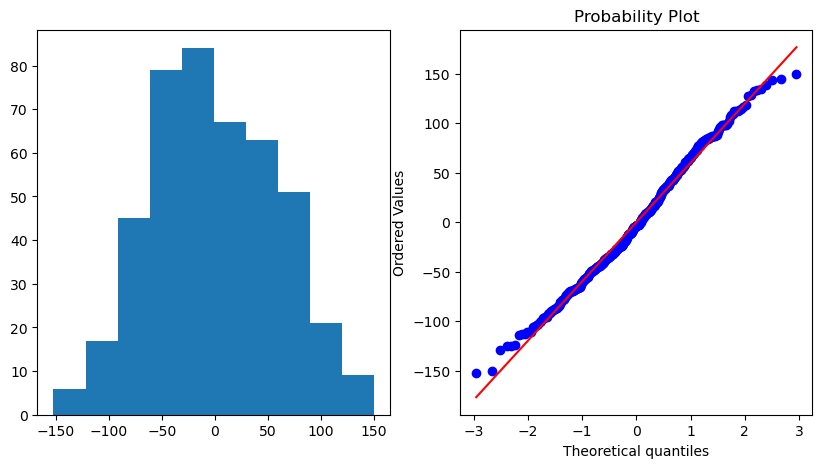

In [14]:
from scipy.stats import zscore, probplot
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import jarque_bera

X_ = sm.add_constant(X)
model = sm.OLS(y, X_)
fitted = model.fit()
resid = fitted.resid
pred = fitted.fittedvalues
sresid = zscore(resid)

print(f"pred: \n {pred[:5].values}")
print(f"obs: \n {y[:5].values.ravel()}")
print(f"resid: \n {resid[:5].values}")
print(f"s resid: \n {sresid[:5].values}")

print("1. 정규성 가정 확인: ") # 히스토그램, QQ plot, Jarque-Bera
stats, p, skew, kurt = jarque_bera(resid)
print(f" Jarque-bera: stats {stats:.3f}, pvalue {p:.3f}")
print(f" skew : {skew:.3f}, kurt : {kurt:.3f}") # 정규분포의 왜도 0, 첨도 3

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(resid)
probplot(resid, plot=ax[1])
plt.show()

2. 등분산성 가정 확인: 


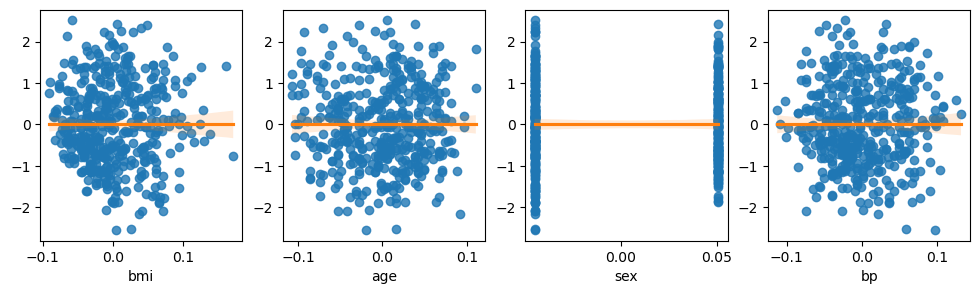

In [18]:
import seaborn as sns

print("2. 등분산성 가정 확인: ")
fig, ax = plt.subplots(1,4, figsize=(12,3))
for feature, ax in zip(X.columns, ax.ravel()):
    sns.regplot(x=X[feature], y=sresid, line_kws={'color':'C1'}, ax=ax)
plt.show()
# 표준화 잔차 값이 +/-2를 벗어나면 이상값 또는 특이값 예상

In [20]:
from statsmodels.stats.stattools import durbin_watson
print("3. 독립성 가정 확인: ")
dw = durbin_watson(resid)
print(f" durbin_watson stat : {dw:.3f}")
# dw이 2에 가까우면 잔차간 독립이고, 0에 가까우면 양의 상관, 4에 가까우면 음의 상관

3. 독립성 가정 확인: 
 durbin_watson stat : 1.933


### 8-1-3 규제 선형회귀
- 잔차의 최소제곱합을 최소화하도록 회귀계수를 최적화 하는 동시에, 페널티 함수를 수식에 추가하는 규제적용
- 회귀 계수들의 값과 모델이 과적합 방지
- 릿지 회귀
  - $\sum^n_{i=1}(y_i-\hat{y_i})^2 + \alpha\sum^p_{j=1}\beta^2_j$를 최소화하는 회귀계수들의 값을 찾음. 회귀 계수에 $L_2$규제. 회귀계수의 절대값을 가능한 한 작게
  - 작은 데이터셋에서는 릿지가 좋지만, 데이터가 충분히 많아지면 규제항은 덜 중요해져서 릿지 회귀와 선형 회귀의 성능이 비슷해짐
- 라쏘 회귀
  - $\sum^n_{i=1}(y_i-\hat{y_i})^2 + \alpha\sum^p_{j=1}|\beta_j|$를 최소화하는 회귀계수들의 값을 찾음. 회귀 계수에 $L_1$규제. 회귀계수를 0에 가깝게. 어떤 특성은 제거 됨
  - 해석이 쉬움
- 엘라스틱 넷 : 릿지, 라소 규제 결합
  - L1 ratio로 조절

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet

X = diabetes.filter(['bmi', 'age', 'sex', 'bp'])
y = diabetes.filter(['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y)

print("\nRidge Regression\n")
a = 0.9
ridge = Ridge(alpha=a).fit(X_train, y_train)
print(f"alpha = {a}")
train_s = ridge.score(X_train, y_train)
test_s = ridge.score(X_test, y_test)
print(f" train set score {train_s:.3f}, test set score {test_s:.3f}")
for i, coef in enumerate(ridge.coef_.ravel()):
    print(f" coef {i} : {coef:.2f}")
print(f" intercept: {ridge.intercept_[0]}")

a = 0.1
ridge = Ridge(alpha=a).fit(X_train, y_train)
print(f"alpha = {a}")
train_s = ridge.score(X_train, y_train)
test_s = ridge.score(X_test, y_test)
print(f" train set score {train_s:.3f}, test set score {test_s:.3f}")
for i, coef in enumerate(ridge.coef_.ravel()):
    print(f" coef {i} : {coef:.2f}")
print(f" intercept: {ridge.intercept_[0]}")

print("\nLasso Regression\n")
a = 0.9
lasso = Lasso(alpha=a).fit(X_train, y_train)
print(f"alpha = {a}")
train_s = lasso.score(X_train, y_train)
test_s = lasso.score(X_test, y_test)
print(f" train set score {train_s:.3f}, test set score {test_s:.3f}")
for i, coef in enumerate(lasso.coef_.ravel()):
    print(f" coef {i} : {coef:.2f}")
print(f" intercept: {lasso.intercept_[0]}")

a = 0.1
lasso = Lasso(alpha=a).fit(X_train, y_train)
print(f"alpha = {a}")
train_s = lasso.score(X_train, y_train)
test_s = lasso.score(X_test, y_test)
print(f" train set score {train_s:.3f}, test set score {test_s:.3f}")
for i, coef in enumerate(lasso.coef_.ravel()):
    print(f" coef {i} : {coef:.2f}")
print(f" intercept: {lasso.intercept_[0]}")

print("\nElastic Net Regression\n")
a = 0.1; l1_ratio = 0.1
en = ElasticNet(alpha=a, l1_ratio=l1_ratio).fit(X_train, y_train)
print(f"alpha = {a}")
train_s = en.score(X_train, y_train)
test_s = en.score(X_test, y_test)
print(f" train set score {train_s:.3f}, test set score {test_s:.3f}")
for i, coef in enumerate(en.coef_.ravel()):
    print(f" coef {i} : {coef:.2f}")
print(f" intercept: {en.intercept_[0]}")

a = 0.1; l1_ratio = 0.9
en = ElasticNet(alpha=a, l1_ratio=l1_ratio).fit(X_train, y_train)
print(f"alpha = {a}")
train_s = en.score(X_train, y_train)
test_s = en.score(X_test, y_test)
print(f" train set score {train_s:.3f}, test set score {test_s:.3f}")
for i, coef in enumerate(en.coef_.ravel()):
    print(f" coef {i} : {coef:.2f}")
print(f" intercept: {en.intercept_[0]}")



Ridge Regression

alpha = 0.9
 train set score 0.331, test set score 0.271
 coef 0 : 383.79
 coef 1 : 72.63
 coef 2 : 3.13
 coef 3 : 277.49
 intercept: 150.96920681112442
alpha = 0.1
 train set score 0.418, test set score 0.320
 coef 0 : 692.11
 coef 1 : 55.51
 coef 2 : -69.01
 coef 3 : 449.96
 intercept: 150.1965038335207

Lasso Regression

alpha = 0.9
 train set score 0.336, test set score 0.297
 coef 0 : 490.77
 coef 1 : 0.00
 coef 2 : 0.00
 coef 3 : 197.38
 intercept: 151.2084483571497
alpha = 0.1
 train set score 0.419, test set score 0.318
 coef 0 : 742.57
 coef 1 : 0.00
 coef 2 : -30.55
 coef 3 : 453.72
 intercept: 150.2480937410907

Elastic Net Regression

alpha = 0.1
 train set score 0.030, test set score 0.026
 coef 0 : 23.53
 coef 1 : 7.42
 coef 2 : 3.30
 coef 3 : 19.08
 intercept: 152.1126324004165
alpha = 0.1
 train set score 0.175, test set score 0.150
 coef 0 : 161.35
 coef 1 : 38.37
 coef 2 : 8.45
 coef 3 : 124.24
 intercept: 151.65138155369618


### 8-1-4 일반화 선형회귀
- 정규분포를 따르지 않는 종속변수에 적절한 함수를 적용하여 예측변수에 따라 선형적으로 변화하도록 하는 회귀모델 기법
- 종속변수에 적용하는 함수를 연결함수라고 하며, 종속변수의 확률분포에 따라 일반적으로 사용하는 연결함수가 정해져 있음
  
[종속변수의 확률분포에 따른 표준연결함수와 평균함수]
- $\mu$는 반응변수의 기댓값, $X\beta$는 예측변수들의 선형결합
- exponential, gammba distribution: negative inverse $$ X\beta=-\mu^{-1}, \mu = -(X\beta)^{-1} $$
- poisson distribution : log $$ X\beta=log(\mu), \mu=exp(X\beta)$$
- bernoulli, multinomial distribution: logit $$ X\beta = log(\frac{\mu}{1-\mu}), \mu = \frac{1}{1+exp(-X\beta)} $$
- binomial distribution : logit $$ X\beta = log(\frac{\mu}{n-\mu}, \mu = \frac{1}{1+exp(-X\beta)}) $$
  
[많이 사용하는 GLM]
- 로지스틱회귀 : 종속변수가 0,1 인 경우. 종속변수의 확률분포가 bernoulli이기 때문에 연결함수로 logit function 적용
- 포아송회귀 : 종속변수가 개수, 빈도를 나타내는 경우. 종속변수의 확률분포가 poisson이기 때문에 연결함수로 log function 적용

- 로지스틱 회귀
  
[선형 회귀와 로지스틱 회귀 비교]
- 선형회귀
  - 최소제곱법으로 최적 회귀계수 찾기
- 로지스틱 회귀
  - 종속변수에 연결함수 logit function 적용
  - 최대우도추정을 사용해 모델 적합, 예상 로그 오즈비가 관찰된 결과를 가장 잘 설명하는 모델 찾기
  - 모델에서 잔차의 특징 분석 불가능
  - 이상치에 민감하고, 표본의 크기가 너무 작으면 추정치 불안할 수 있음
- 오즈비 : 다른 특성들의 값은 동일한 상태에서 특정한 특성 x의 한 단위가 증가하면, 증가후 y의 오즈가 증가 전 y의 오즈의 'exp(특정 x 회귀게수'배가 됨, 이때 exp(회귀계수)값이 오즈비 246